In [1]:
# General
import pandas as pd
import numpy as np
from time import time
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from ast import literal_eval

# Word2Vec
import multiprocessing
from gensim.models import Word2Vec
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Create and Train Model

The 'parsed_trainfile.csv' can be found in the Processed JSONs folder in th shared drive - https://drive.google.com/drive/folders/1eDEeQldaYod7bWUD1Sr9Q3KaP_MzNK9X?usp=sharing

In [2]:
# change path to location where data is stored
reldatapath = '../data/'
filepath = 'parsed_trainfile.csv'
df = pd.read_csv(reldatapath+filepath)
df.ingredients = [literal_eval(x) for x in df.ingredients]
df = df.drop(columns = ['Unnamed: 0'])

# Clean ingredients further with manually observed tokens
stopwords = ['chopped','diced','sliced','minced','10','oz','roughly','cut','half',10,"'10'", 'grams', 'slices','peeled','divided','g','t','','.','x','cubed','trimmed','sm','lg','possibly',
'ml','slice','grated']
def clean_ing(ingr_list):
    new_words = []
    for word in ingr_list:
        new_ing = []
        split = word.split()
        for subword in split:
            if subword.lower() not in stopwords:
                new_ing.append(subword.lower())
        new_ing = ' '.join(new_ing)
        new_words.append(new_ing)
    return new_words

df.ingredients = df.ingredients.apply(clean_ing)
df['titlelist'] = [str(row).split() for row in df.title.values]
df['words'] = df.ingredients + df.titlelist

pretrained model can be found in the 'models' folder in the shared drive - https://drive.google.com/drive/folders/1I0fis_QXvMf3_R9H2T1LS8uqK2ywPVQn?usp=sharing

In [3]:
# # load w2v model if already trained
relmodelpath = '../models/'
w2v_model = Word2Vec.load(relmodelpath+'word_embedding_model.model')

# # Retrain or create new model -- uncomment below
# create W2V model
# cores = multiprocessing.cpu_count() # Count the number of cores in a computer
# w2v_model = Word2Vec(min_count=200,
#                      window=10,
#                      vector_size=3000,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,
#                      workers=cores-1)
# t = time()
# w2v_model.build_vocab(df.words, progress_per=10000)
# print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

# # Train W2V model (~6 min)
# t = time()
# w2v_model.train(df.words, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)
# print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# # save model
# w2v_model.save('../models/word_embedding_model.model')

INFO - 16:35:47: loading Word2Vec object from ../models/word_embedding_model.model
INFO - 16:35:47: loading wv recursively from ../models/word_embedding_model.model.wv.* with mmap=None
INFO - 16:35:47: loading vectors from ../models/word_embedding_model.model.wv.vectors.npy with mmap=None
INFO - 16:35:47: loading syn1neg from ../models/word_embedding_model.model.syn1neg.npy with mmap=None
INFO - 16:35:47: setting ignored attribute cum_table to None
INFO - 16:35:47: Word2Vec lifecycle event {'fname': '../models/word_embedding_model.model', 'datetime': '2022-10-23T16:35:47.448527', 'gensim': '4.1.2', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


In [4]:
# Manually search for terms in model
term = 'breakfast'
w2v_model.wv.most_similar(positive=[term])

[('brunch', 0.6563355326652527),
 ('morning', 0.5705249309539795),
 ('strata', 0.4545081853866577),
 ('scramble', 0.453914612531662),
 ('overnight', 0.4310278296470642),
 ('muffin', 0.4223579168319702),
 ('scrambled', 0.40977051854133606),
 ('omelet', 0.40105628967285156),
 ('baking mix', 0.3952378034591675),
 ('waffle', 0.3949027359485626)]

# Plotting with t-SNE

In [5]:
# helper function for plotting t-SNE
# source for original function - https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.nipy_spectral(np.linspace(0, .95, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        ax = plt.gca()
        ax.scatter(x, y, color=color, label=label, s=60)
        for i, word in enumerate(words):
                ax.annotate(word, alpha=.85, xy=(x[i], y[i]), xytext=(5, 2),
                             textcoords='offset points', ha='right', va='bottom', size=12, weight='bold')
                             
    plt.legend(bbox_to_anchor = (1.15,1), fontsize=14)
    ax.set_title(title, size=18, weight='bold')

    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


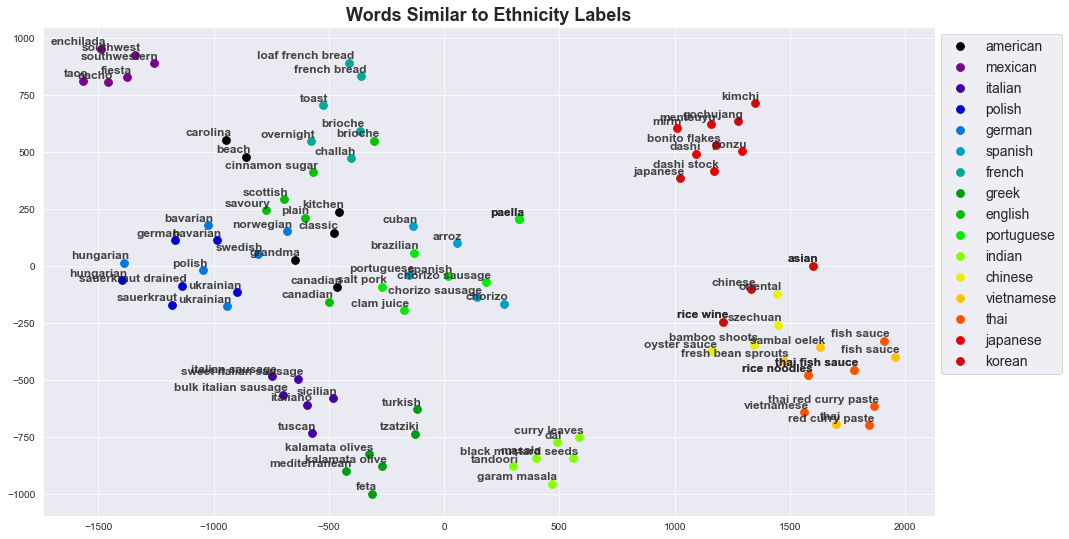

In [6]:
# Plot ethnicity labels
keys = ['american','mexican',
        'italian','polish','german','spanish','french','greek','english','portuguese',
        'indian','chinese','vietnamese','thai','japanese','korean',
       ]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=6):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=9, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Words Similar to Ethnicity Labels', keys, embeddings_en_2d, word_clusters, .85,'ethnicity_similar_words.png')

c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\jrmcn\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


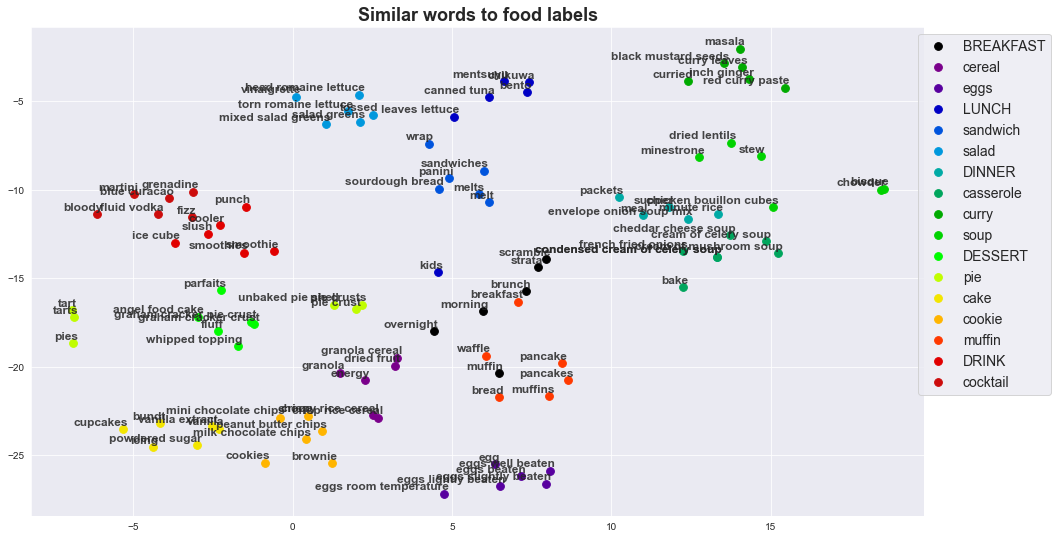

In [7]:
# plot food categories
keys = [
    'BREAKFAST', 'cereal', 'eggs',
    'LUNCH', 'sandwich','salad',
    'DINNER', 'casserole','curry','soup',
    'DESSERT', 'pie','cake','cookie','muffin',
    'DRINK','cocktail'
       ]


embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word.lower(), topn=6):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=16, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words to food labels', keys, embeddings_en_2d, word_clusters, 0.7,'foodlabels_similar_words.png')